Skrypt sprawdzający ilość wyróżnionych prac naukowych (na podstronie) danego pracownika wydziału.

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
import pandas as pd
import time
import re

In [5]:
# otwarcie strony
driver = webdriver.Firefox()
driver.get("https://ms.polsl.pl/pracownicy.php")

In [ ]:
# lista pracowników
employeeList = driver.find_element(By.ID, "content")

# poszczególne rekordy listy
rows = employeeList.find_elements(By.XPATH, ".//a[@class='light' and starts-with(@href, 'pracownik.php?kod=')]")
print("Ilość znalezionych rekordów: ", len(rows))

# zmienna na dane pracowników
employeeData = []

# zmienna na potrzeby testów - ograniczająca liczbę scrapowanych rekordów
i = 0

for row in rows:

    # zmienna pomocnicza
    # i += 1
    # if(i>5):
    #     break
    
    # wyciągnięcie imienia
    employeeDesc = row.find_element(By.CLASS_NAME, "pracownik")
    text = employeeDesc.find_element(By.TAG_NAME, "strong")
    text = text.get_attribute("innerHTML")
    name = text.split("<br>")[0]
    regex = r"dr |hab\.|inż\.|prof\.|mgr|lic\.|dziekan|prodziekan|PŚ|\,|<.*?>"
    name = re.sub(regex, "", name)
    name = name.strip()
    lastName = name.split(" ")[-1]

    # wyciągnięcie linku
    link = employeeDesc.find_element(By.CLASS_NAME, "pracownik-foto")
    
    # przescrollowanie do linku
    driver.execute_script("arguments[0].scrollIntoView();", link)

    # otwarcie linku w nowej karcie
    webdriver.ActionChains(driver).key_down(Keys.CONTROL).click(link).key_up(Keys.CONTROL).perform()

    # zmiana okna
    current_window = driver.current_window_handle
    windows = driver.window_handles
    driver.switch_to.window(windows[-1])
    
    # poczekanie na załadowanie w nowootwartej karcie
    mailtoLink = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//div[@style='text-align: left']"))    
    )

    # proces wyciągnięcia prac naukowych
    allData = driver.find_element(By.ID, "content")
    ilosc = 0

    # sprawdzenie czy jest sekcja z pracami naukowymi
    if "Najważniejsze prace naukowe:" not in allData.text:
        # print("Nie znaleziono sekcji z pracami naukowymi")

        # dodanie do listy
        employeeData.append([name, ilosc])
        print("Dodano: ", name, " ilość prac: ", ilosc)

        # zamknięcie karty
        driver.close()
        driver.switch_to.window(current_window)
        continue

    # obcięcie od "Najważniejsze prace naukowe:" do końca
    publicationsData = allData.text.split("Najważniejsze prace naukowe:")[-1] 
    # print("publicationsData", publicationsData)

    # stworzenie listy
    publications = [x.strip() for x in publicationsData.split("\n") if x.strip()]

    # zliczenie po ilości wystąpień podpunktów
    wzorzecPodpunktow = re.compile(r"^.?(\d{1,2})\D.*")
    ilosc = sum(bool(wzorzecPodpunktow.match(element)) for element in publications)

    # powrót do poprzedniego okna
    driver.close()
    driver.switch_to.window(current_window)

    # dodanie do listy
    employeeData.append([name, ilosc])
    print("Dodano: ", name, " ilość prac: ", ilosc)
    
print(employeeData)
# >> 4, 3, 0, ...

Ilość znalezionych rekordów:  74
Dodano:  Marcin Adam  ilość prac:  4
Dodano:  Katarzyna Adrianowicz  ilość prac:  3
Dodano:  Orest Artemovych  ilość prac:  0
Dodano:  Lech Bartłomiejczyk  ilość prac:  0
Dodano:  Agnieszka Bier  ilość prac:  5
Dodano:  Barbara Biły  ilość prac:  5
Dodano:  Marek Błasik  ilość prac:  0
Dodano:  Mykola Bratiichuk  ilość prac:  4
Dodano:  Rafał Brociek  ilość prac:  0
Dodano:  Giacomo Capizzi  ilość prac:  0
Dodano:  Robertas Damaševičius  ilość prac:  0
Dodano:  Ewelina Domalik  ilość prac:  0
Dodano:  Ryszard Frankiewicz  ilość prac:  0
Dodano:  Michał Gacki  ilość prac:  0
Dodano:  Henryk Gacki  ilość prac:  13
Dodano:  Piotr Gawron  ilość prac:  5
Dodano:  Zuzanna Grabarz  ilość prac:  0
Dodano:  Edyta Hetmaniok  ilość prac:  5
Dodano:  Waldemar Hołubowski  ilość prac:  5
Dodano:  Krzysztof Jelito  ilość prac:  0
Dodano:  Konrad Kaczmarek  ilość prac:  2
Dodano:  Adrian Kapczyński  ilość prac:  4
Dodano:  Jarosław Karcewicz  ilość prac:  4
Dodano:  Wo

In [7]:
# strukturyzacja danych
df = pd.DataFrame(employeeData, columns=["Imie Nazwisko", "Ilość"])

# ewentualny eksport do pliku CSV
# df.to_csv('prace-naukowe.csv', index=False)

# ewentualny import z pliku CSV
# df = pd.read_csv('./outputs/prace-naukowe-good.csv')

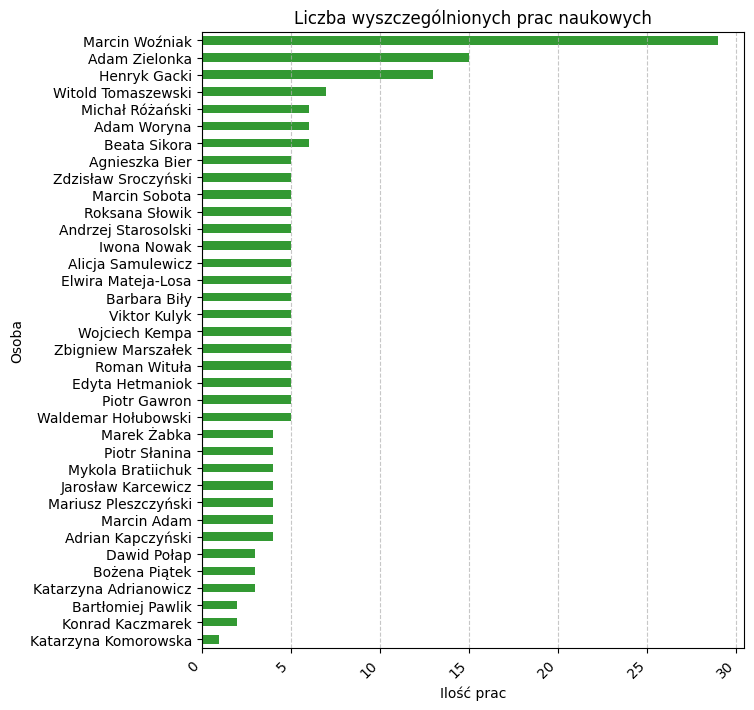

In [8]:
# wizualizacja danych - wykres

# df = df.nlargest(30, 'Ilość')
df = df[df["Ilość"] > 0]
df.sort_values('Ilość', ascending=True).plot(
# df.sort_values("Imie Nazwisko", ascending=False).plot(
# df.plot(
    x='Imie Nazwisko', 
    y='Ilość', 
    kind='barh', 
    legend=False, 
    color='green', 
    alpha=0.8,
    figsize=(7, 8)
)

plt.xlabel('Ilość prac')
plt.ylabel('Osoba')
plt.title('Liczba wyszczególnionych prac naukowych')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
